# **1. Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import random
import math
from scipy import stats
import scikit_posthocs as sp
from joblib import Parallel, delayed

# TDA
import kmapper as km
import dyneusr as dsr
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN
from kmapper.cover import Cover
from tmap.tda.utils import optimize_dbscan_eps

In [3]:
# Set seed for reproducibility
seed_value = 10
random.seed(seed_value)

# **2. Import data**

In [4]:
smri_data_path = '/Users/stefanovannoni/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Dottorato/Tesi Magistrale/Data/sMRI_data.csv'
env_data_path = '/Users/stefanovannoni/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Dottorato/Tesi Magistrale/Data/env_data.csv'
fmri_data_path = '/Users/stefanovannoni/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Dottorato/Tesi Magistrale/Data/data.csv'

# Load data
smri_data = pd.read_csv(smri_data_path)
env_data = pd.read_csv(env_data_path)
fmri_data = pd.read_csv(fmri_data_path)

# Remove class labels
x_smri = smri_data.drop('study_group', axis=1)
x_env = env_data.drop('study_group', axis=1)
x_fmri = fmri_data.drop('study_group', axis=1)

# Class labels
y = smri_data['study_group']
y_dummy = pd.get_dummies(y)
y_dummy = y_dummy.astype(int)

# Print data shape
print('sMRI data shape: ', x_smri.shape)
print('fMRI data shape: ', x_fmri.shape)
print('Env data shape: ', x_env.shape)

sMRI data shape:  (587, 68)
fMRI data shape:  (587, 12720)
Env data shape:  (587, 23)


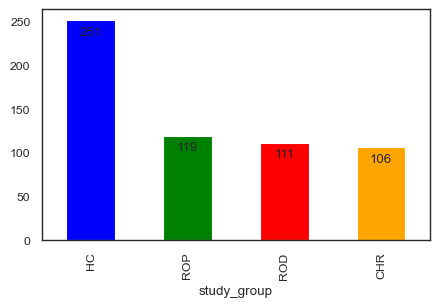

In [5]:
# Class labels histogram
labels_freq = y.value_counts()
colors_ = ['blue', 'green', 'red', 'orange']

plt.figure(figsize=(5, 3))
labels_freq.plot(kind='bar', color=colors_)

for i, valore in enumerate(labels_freq):
    plt.text(i, valore - 20, str(valore), ha='center', va='bottom')

plt.show()

In [6]:
# Only HC samples
smri_hc = smri_data[smri_data['study_group'] == 'HC']
env_hc = env_data[env_data['study_group'] == 'HC']
fmri_hc = fmri_data[fmri_data['study_group'] == 'HC']

# Drop class labels
smri_hc = smri_hc.drop('study_group', axis=1)
env_hc = env_hc.drop('study_group', axis=1)
fmri_hc = fmri_hc.drop('study_group', axis=1)

In [7]:
# Patient samples
smri_rop = smri_data[smri_data['study_group'] == 'ROP']
smri_rod = smri_data[smri_data['study_group'] == 'ROD']
smri_chr = smri_data[smri_data['study_group'] == 'CHR']

env_rop = env_data[env_data['study_group'] == 'ROP']
env_rod = env_data[env_data['study_group'] == 'ROD']
env_chr = env_data[env_data['study_group'] == 'CHR']

fmri_rop = fmri_data[fmri_data['study_group'] == 'ROP']
fmri_rod = fmri_data[fmri_data['study_group'] == 'ROD']
fmri_chr = fmri_data[fmri_data['study_group'] == 'CHR']

# Drop class labels
smri_rop = smri_rop.drop('study_group', axis=1)
smri_rod = smri_rod.drop('study_group', axis=1)
smri_chr = smri_chr.drop('study_group', axis=1)

env_rop = env_rop.drop('study_group', axis=1)
env_rod = env_rod.drop('study_group', axis=1)
env_chr = env_chr.drop('study_group', axis=1)

fmri_rop = fmri_rop.drop('study_group', axis=1)
fmri_rod = fmri_rod.drop('study_group', axis=1)
fmri_chr = fmri_chr.drop('study_group', axis=1)

# **3. Project data (Filtering)**

In [8]:
# Isomap
isomap_env = Isomap(n_components=2)
isomap_smri = Isomap(n_components=2)
isomap_fmri = Isomap(n_components=2)

# smri
isomap_smri.fit(smri_hc)

# fmri
isomap_fmri.fit(fmri_hc)

# env
isomap_env.fit(env_hc)

Isomap()

In [9]:
# Projection into 2D
x_smri_isomap = isomap_smri.transform(x_smri)
x_fmri_isomap = isomap_fmri.transform(x_fmri)
x_env_isomap = isomap_env.transform(x_env)

# **4. TDA**

In [10]:
mapper_env = km.KeplerMapper(verbose=0)
mapper_smri = km.KeplerMapper(verbose=0)
mapper_fmri = km.KeplerMapper(verbose=0)

In [11]:
# Create lens function
lens_env = mapper_env.fit_transform(isomap_env.fit_transform(env_hc), projection=[0, 1], scaler=None)
lens_smri = mapper_smri.fit_transform(isomap_smri.fit_transform(smri_hc), projection=[0, 1], scaler=None)
lens_fmri = mapper_fmri.fit_transform(isomap_fmri.fit_transform(fmri_hc), projection=[0, 1], scaler=None)

# **5. Framework application**

In [12]:
def mapping_tda(data, sample, cover):
    # Add index column to data
    idx = np.arange(data.shape[0])[:, np.newaxis]
    data = np.hstack((idx, data))

    # Fit cover and get cube centers
    bins = cover.fit(data)
    bins = [(sublist[0], sublist[1]) for sublist in bins]

    # Transform data into hypercubes
    hypercubes = cover.transform(data, bins)

    # Find indices of cubes containing the sample
    index_cubes = cover.find(sample)

    # Get indices of matching hypercubes
    hypercubes_index = []
    for index in index_cubes:
        cube = cover.transform_single(data, bins[index])

        for j in range(len(hypercubes)):
            if np.array_equal(cube, hypercubes[j]):
                hypercubes_index.append(j)

    # # Print hypercubes with only one sample
    # for k in hypercubes_index:
    #     if len(hypercubes[k]) == 1:
    #         print(f'Hyper cube {k} with only one sample')
    #     else:
    #         continue

    # Return indices, hypercubes, and centers
    return hypercubes_index, hypercubes, bins

In [13]:
def get_barycenter(hypercubes):
    hypercubes_coordinates = {}
    for i, cube in enumerate(hypercubes):
        points = cube[:, 1:]
        points_center = np.mean(points, axis=0)
        hypercubes_coordinates[i] = [points_center, len(points)]

    sum_x = 0
    sum_y = 0
    total_points = 0

    # Compute weighted barycenter
    for point in hypercubes_coordinates.values():
        coordinates, weight = point
        x, y = coordinates
        sum_x += x * weight
        sum_y += y * weight
        total_points += weight

    barycenter = [sum_x / total_points, sum_y / total_points]

    return barycenter

In [14]:
# Define Cover parameters ranges
res_range = [0.52, 0.54, 0.56, 0.58, 0.60, 0.62, 0.64, 0.66, 0.68]
gain_range = [20, 25, 30, 35, 40, 45, 50, 55, 60]

n_res = len(res_range)
n_gain = len(gain_range)

n_iteration = n_res * n_gain
print(f'Number of iterations: {n_iteration}')

Number of iterations: 81


## **5.1. Grid Search**

### **5.1.1. ENV features**

In [15]:
env_results = {}

for i, res in enumerate(res_range):
    for j, gain in enumerate(gain_range):
        print(f'Cover parameters: {res}, {gain}, iteration: {i+1} out of {len(res_range)}')
        if j == 8:
            print('==========================')

        # TDA GRAPH CREATION
        cover = Cover(n_cubes=gain, perc_overlap=res)
        graph = mapper_env.map(
            lens=lens_env,
            X=env_hc,
            cover=cover,
            clusterer=DBSCAN(eps=optimize_dbscan_eps(env_hc, threshold=95), min_samples=2)
        )
        graph_nx = km.adapter.to_nx(graph)
        nodes_index = [int(element.split('cube')[1].split('_')[0]) for element in list(graph_nx.nodes())]
        n_nodes = len(nodes_index)

        #################################################################################################################################################

        # BARYCENTER
        idx = np.arange(x_env_isomap.shape[0])[:, np.newaxis]
        new_data = np.hstack((idx, x_env_isomap))
        bins = cover.fit(new_data)
        bins = [(sublist[0], sublist[1]) for sublist in bins]
        hypercubes = cover.transform(new_data, bins)
        hypercubes_ = [cube for i, cube in enumerate(hypercubes) if i in nodes_index] # Get nodes hypercubes
        barycenter = get_barycenter(hypercubes_)

        # NODES DISTANCE FROM BARYCENTER
        hc_distance = []
        for cube in hypercubes_:
            center = np.mean(cube[:, 1:], axis=0)
            hc_distance.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

        #################################################################################################################################################
                    
        # PATIENT SAMPLES PROJECTION
            
        # ROP
        rop_distance = []
        rop_distance_not_mapped = []
        for k in range(len(env_rop)):
            patient = env_rop.iloc[[k]]
            patient_isomap = isomap_env.transform(patient)

            # Mapping
            hypercubes_index_rop, hypercubes_rop, bins_rop = mapping_tda(x_env_isomap, patient_isomap, cover)

            if len(hypercubes_index_rop) > 0:
                rop_dist = []
                for index in hypercubes_index_rop:
                    if index in nodes_index:
                        cube = hypercubes_rop[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        rop_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rop_distance.append(np.mean(np.array(rop_dist)))
            else:
                rop_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        rop_noisy = len([value for value in rop_distance if math.isnan(value)])
        rop_distance = [value for value in rop_distance if not math.isnan(value)]
        rop_not_mapped = len(rop_distance_not_mapped)

        #############################################

        # ROD
        rod_distance = []
        rod_distance_not_mapped = []
        for k in range(len(env_rod)):
            patient = env_rod.iloc[[k]]
            patient_isomap = isomap_env.transform(patient)

            # Mapping
            hypercubes_index_rod, hypercubes_rod, bins_rod = mapping_tda(x_env_isomap, patient_isomap, cover)

            if len(hypercubes_index_rod) > 0:
                rod_dist = []
                for index in hypercubes_index_rod:
                    if index in nodes_index:
                        cube = hypercubes_rod[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        rod_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rod_distance.append(np.mean(np.array(rod_dist)))
            else:
                rod_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        rod_noisy = len([value for value in rod_distance if math.isnan(value)])
        rod_distance = [value for value in rod_distance if not math.isnan(value)]
        rod_not_mapped = len(rod_distance_not_mapped)

        #############################################

        # CHR
        chr_distance = []
        chr_distance_not_mapped = []
        for k in range(len(env_chr)):
            patient = env_chr.iloc[[k]]
            patient_isomap = isomap_env.transform(patient)

            # Mapping
            hypercubes_index_chr, hypercubes_chr, bins_chr = mapping_tda(x_env_isomap, patient_isomap, cover)
            
            if len(hypercubes_index_chr) > 0:
                chr_dist = []
                for index in hypercubes_index_chr:
                    if index in nodes_index:
                        cube = hypercubes_chr[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        chr_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                chr_distance.append(np.mean(np.array(chr_dist)))
            else:
                chr_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        chr_noisy = len([value for value in chr_distance if math.isnan(value)])
        chr_distance = [value for value in chr_distance if not math.isnan(value)]
        chr_not_mapped = len(chr_distance_not_mapped)

        #################################################################################################################################################

        # RESULTS
        env_results[tuple((res, gain))] = [hc_distance, n_nodes, rop_distance, rop_distance_not_mapped, rop_not_mapped, rop_noisy, rod_distance, rod_distance_not_mapped, rod_not_mapped, rod_noisy, chr_distance, chr_distance_not_mapped, chr_not_mapped, chr_noisy]

Cover parameters: 0.52, 20, iteration: 1 out of 9
Cover parameters: 0.52, 25, iteration: 1 out of 9
Cover parameters: 0.52, 30, iteration: 1 out of 9
Cover parameters: 0.52, 35, iteration: 1 out of 9
Cover parameters: 0.52, 40, iteration: 1 out of 9
Cover parameters: 0.52, 45, iteration: 1 out of 9
Cover parameters: 0.52, 50, iteration: 1 out of 9
Cover parameters: 0.52, 55, iteration: 1 out of 9
Cover parameters: 0.52, 60, iteration: 1 out of 9
Cover parameters: 0.54, 20, iteration: 2 out of 9
Cover parameters: 0.54, 25, iteration: 2 out of 9
Cover parameters: 0.54, 30, iteration: 2 out of 9
Cover parameters: 0.54, 35, iteration: 2 out of 9
Cover parameters: 0.54, 40, iteration: 2 out of 9
Cover parameters: 0.54, 45, iteration: 2 out of 9
Cover parameters: 0.54, 50, iteration: 2 out of 9
Cover parameters: 0.54, 55, iteration: 2 out of 9
Cover parameters: 0.54, 60, iteration: 2 out of 9
Cover parameters: 0.56, 20, iteration: 3 out of 9
Cover parameters: 0.56, 25, iteration: 3 out of 9


### **5.1.2. sMRI features**

In [16]:
smri_results = {}

for i, res in enumerate(res_range):
    for j, gain in enumerate(gain_range):
        print(f'Cover parameters: {res}, {gain}, iteration: {i+1} out of {len(res_range)}')
        if j == 8:
            print('==========================')

        # TDA GRAPH CREATION
        cover = Cover(n_cubes=gain, perc_overlap=res)
        graph = mapper_smri.map(
            lens=lens_smri,
            X=smri_hc,
            cover=cover,
            clusterer=DBSCAN(eps=optimize_dbscan_eps(smri_hc, threshold=95), min_samples=2)
        )
        graph_nx = km.adapter.to_nx(graph)
        nodes_index = [int(element.split('cube')[1].split('_')[0]) for element in list(graph_nx.nodes())]
        n_nodes = len(nodes_index)

        #################################################################################################################################################

        # BARYCENTER
        idx = np.arange(x_smri_isomap.shape[0])[:, np.newaxis]
        new_data = np.hstack((idx, x_smri_isomap))
        bins = cover.fit(new_data)
        bins = [(sublist[0], sublist[1]) for sublist in bins]
        hypercubes = cover.transform(new_data, bins)
        hypercubes_ = [cube for i, cube in enumerate(hypercubes) if i in nodes_index] # Get nodes hypercubes
        barycenter = get_barycenter(hypercubes_)

        # NODES DISTANCE FROM BARYCENTER
        hc_distance = []
        for cube in hypercubes_:
            center = np.mean(cube[:, 1:], axis=0)
            hc_distance.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

        #################################################################################################################################################
                    
        # PATIENT SAMPLES PROJECTION
            
        # ROP
        rop_distance = []
        rop_distance_not_mapped = []
        for k in range(len(smri_rop)):
            patient = smri_rop.iloc[[k]]
            patient_isomap = isomap_smri.transform(patient)

            # Mapping
            hypercubes_index_rop, hypercubes_rop, bins_rop = mapping_tda(x_smri_isomap, patient_isomap, cover)

            if len(hypercubes_index_rop) > 0:
                rop_dist = []
                for index in hypercubes_index_rop:
                    if index in nodes_index:
                        cube = hypercubes_rop[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        rop_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rop_distance.append(np.mean(np.array(rop_dist)))
            else:
                rop_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        rop_noisy = len([value for value in rop_distance if math.isnan(value)])
        rop_distance = [value for value in rop_distance if not math.isnan(value)]
        rop_not_mapped = len(rop_distance_not_mapped)

        #############################################

        # ROD
        rod_distance = []
        rod_distance_not_mapped = []
        for k in range(len(smri_rod)):
            patient = smri_rod.iloc[[k]]
            patient_isomap = isomap_smri.transform(patient)

            # Mapping
            hypercubes_index_rod, hypercubes_rod, bins_rod = mapping_tda(x_smri_isomap, patient_isomap, cover)

            if len(hypercubes_index_rod) > 0:
                rod_dist = []
                for index in hypercubes_index_rod:
                    if index in nodes_index:
                        cube = hypercubes_rod[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        rod_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rod_distance.append(np.mean(np.array(rod_dist)))
            else:
                rod_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        rod_noisy = len([value for value in rod_distance if math.isnan(value)])
        rod_distance = [value for value in rod_distance if not math.isnan(value)]
        rod_not_mapped = len(rod_distance_not_mapped)

        #############################################

        # CHR
        chr_distance = []
        chr_distance_not_mapped = []
        for k in range(len(smri_chr)):
            patient = smri_chr.iloc[[k]]
            patient_isomap = isomap_smri.transform(patient)

            # Mapping
            hypercubes_index_chr, hypercubes_chr, bins_chr = mapping_tda(x_smri_isomap, patient_isomap, cover)
            
            if len(hypercubes_index_chr) > 0:
                chr_dist = []
                for index in hypercubes_index_chr:
                    if index in nodes_index:
                        cube = hypercubes_chr[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        chr_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                chr_distance.append(np.mean(np.array(chr_dist)))
            else:
                chr_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        chr_noisy = len([value for value in chr_distance if math.isnan(value)])
        chr_distance = [value for value in chr_distance if not math.isnan(value)]
        chr_not_mapped = len(chr_distance_not_mapped)

        #################################################################################################################################################

        # RESULTS
        smri_results[tuple((res, gain))] = [hc_distance, n_nodes, rop_distance, rop_distance_not_mapped, rop_not_mapped, rop_noisy, rod_distance, rod_distance_not_mapped, rod_not_mapped, rod_noisy, chr_distance, chr_distance_not_mapped, chr_not_mapped, chr_noisy]

Cover parameters: 0.52, 20, iteration: 1 out of 9
Cover parameters: 0.52, 25, iteration: 1 out of 9
Cover parameters: 0.52, 30, iteration: 1 out of 9
Cover parameters: 0.52, 35, iteration: 1 out of 9
Cover parameters: 0.52, 40, iteration: 1 out of 9
Cover parameters: 0.52, 45, iteration: 1 out of 9
Cover parameters: 0.52, 50, iteration: 1 out of 9
Cover parameters: 0.52, 55, iteration: 1 out of 9
Cover parameters: 0.52, 60, iteration: 1 out of 9
Cover parameters: 0.54, 20, iteration: 2 out of 9
Cover parameters: 0.54, 25, iteration: 2 out of 9
Cover parameters: 0.54, 30, iteration: 2 out of 9
Cover parameters: 0.54, 35, iteration: 2 out of 9
Cover parameters: 0.54, 40, iteration: 2 out of 9
Cover parameters: 0.54, 45, iteration: 2 out of 9
Cover parameters: 0.54, 50, iteration: 2 out of 9
Cover parameters: 0.54, 55, iteration: 2 out of 9
Cover parameters: 0.54, 60, iteration: 2 out of 9
Cover parameters: 0.56, 20, iteration: 3 out of 9
Cover parameters: 0.56, 25, iteration: 3 out of 9


### **5.1.3. fMRI features**

In [17]:
fmri_results = {}

for i, res in enumerate(res_range):
    for j, gain in enumerate(gain_range):
        print(f'Cover parameters: {res}, {gain}, iteration: {i+1} out of {len(res_range)}')
        if j == 8:
            print('==========================')

        # TDA GRAPH CREATION
        cover = Cover(n_cubes=gain, perc_overlap=res)
        graph = mapper_fmri.map(
            lens=lens_fmri,
            X=fmri_hc,
            cover=cover,
            clusterer=DBSCAN(eps=optimize_dbscan_eps(fmri_hc, threshold=95), min_samples=2)
        )
        graph_nx = km.adapter.to_nx(graph)
        nodes_index = [int(element.split('cube')[1].split('_')[0]) for element in list(graph_nx.nodes())]
        n_nodes = len(nodes_index)

        #################################################################################################################################################

        # BARYCENTER
        idx = np.arange(x_fmri_isomap.shape[0])[:, np.newaxis]
        new_data = np.hstack((idx, x_fmri_isomap))
        bins = cover.fit(new_data)
        bins = [(sublist[0], sublist[1]) for sublist in bins]
        hypercubes = cover.transform(new_data, bins)
        hypercubes_ = [cube for i, cube in enumerate(hypercubes) if i in nodes_index] # Get nodes hypercubes
        barycenter = get_barycenter(hypercubes_)

        # NODES DISTANCE FROM BARYCENTER
        hc_distance = []
        for cube in hypercubes_:
            center = np.mean(cube[:, 1:], axis=0)
            hc_distance.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

        #################################################################################################################################################
                    
        # PATIENT SAMPLES PROJECTION
            
        # ROP
        rop_distance = []
        rop_distance_not_mapped = []
        for k in range(len(fmri_rop)):
            patient = fmri_rop.iloc[[k]]
            patient_isomap = isomap_fmri.transform(patient)

            # Mapping
            hypercubes_index_rop, hypercubes_rop, bins_rop = mapping_tda(x_fmri_isomap, patient_isomap, cover)

            if len(hypercubes_index_rop) > 0:
                rop_dist = []
                for index in hypercubes_index_rop:
                    if index in nodes_index:
                        cube = hypercubes_rop[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        rop_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rop_distance.append(np.mean(np.array(rop_dist)))
            else:
                rop_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        rop_noisy = len([value for value in rop_distance if math.isnan(value)])
        rop_distance = [value for value in rop_distance if not math.isnan(value)]
        rop_not_mapped = len(rop_distance_not_mapped)

        #############################################

        # ROD
        rod_distance = []
        rod_distance_not_mapped = []
        for k in range(len(fmri_rod)):
            patient = fmri_rod.iloc[[k]]
            patient_isomap = isomap_fmri.transform(patient)

            # Mapping
            hypercubes_index_rod, hypercubes_rod, bins_rod = mapping_tda(x_fmri_isomap, patient_isomap, cover)

            if len(hypercubes_index_rod) > 0:
                rod_dist = []
                for index in hypercubes_index_rod:
                    if index in nodes_index:
                        cube = hypercubes_rod[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        rod_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                rod_distance.append(np.mean(np.array(rod_dist)))
            else:
                rod_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        rod_noisy = len([value for value in rod_distance if math.isnan(value)])
        rod_distance = [value for value in rod_distance if not math.isnan(value)]
        rod_not_mapped = len(rod_distance_not_mapped)

        #############################################

        # CHR
        chr_distance = []
        chr_distance_not_mapped = []
        for k in range(len(fmri_chr)):
            patient = fmri_chr.iloc[[k]]
            patient_isomap = isomap_fmri.transform(patient)

            # Mapping
            hypercubes_index_chr, hypercubes_chr, bins_chr = mapping_tda(x_fmri_isomap, patient_isomap, cover)
            
            if len(hypercubes_index_chr) > 0:
                chr_dist = []
                for index in hypercubes_index_chr:
                    if index in nodes_index:
                        cube = hypercubes_chr[index]
                        center = np.mean(np.concatenate((cube[:, 1:], patient_isomap), axis=0), axis=0)
                        chr_dist.append(math.sqrt((center[0] - barycenter[0]) ** 2 + (center[1] - barycenter[1]) ** 2))

                chr_distance.append(np.mean(np.array(chr_dist)))
            else:
                chr_distance_not_mapped.append(math.sqrt((patient_isomap[0][0] - barycenter[0]) ** 2 + (patient_isomap[0][1] - barycenter[1]) ** 2))

        chr_noisy = len([value for value in chr_distance if math.isnan(value)])
        chr_distance = [value for value in chr_distance if not math.isnan(value)]
        chr_not_mapped = len(chr_distance_not_mapped)

        #################################################################################################################################################

        # RESULTS
        fmri_results[tuple((res, gain))] = [hc_distance, n_nodes, rop_distance, rop_distance_not_mapped, rop_not_mapped, rop_noisy, rod_distance, rod_distance_not_mapped, rod_not_mapped, rod_noisy, chr_distance, chr_distance_not_mapped, chr_not_mapped, chr_noisy]

Cover parameters: 0.52, 20, iteration: 1 out of 9
Cover parameters: 0.52, 25, iteration: 1 out of 9
Cover parameters: 0.52, 30, iteration: 1 out of 9
Cover parameters: 0.52, 35, iteration: 1 out of 9
Cover parameters: 0.52, 40, iteration: 1 out of 9
Cover parameters: 0.52, 45, iteration: 1 out of 9
Cover parameters: 0.52, 50, iteration: 1 out of 9
Cover parameters: 0.52, 55, iteration: 1 out of 9
Cover parameters: 0.52, 60, iteration: 1 out of 9
Cover parameters: 0.54, 20, iteration: 2 out of 9
Cover parameters: 0.54, 25, iteration: 2 out of 9
Cover parameters: 0.54, 30, iteration: 2 out of 9
Cover parameters: 0.54, 35, iteration: 2 out of 9
Cover parameters: 0.54, 40, iteration: 2 out of 9
Cover parameters: 0.54, 45, iteration: 2 out of 9
Cover parameters: 0.54, 50, iteration: 2 out of 9
Cover parameters: 0.54, 55, iteration: 2 out of 9
Cover parameters: 0.54, 60, iteration: 2 out of 9
Cover parameters: 0.56, 20, iteration: 3 out of 9
Cover parameters: 0.56, 25, iteration: 3 out of 9


## **5.2. Print results**

In [18]:
env_results_df = pd.DataFrame.from_dict(env_results, orient='index', columns=['Reference distance (HC)', 'N. nodes', 'ROP distance', 'ROP not mapped distnace', 'N. ROP not mapped', 'N. Noisy ROP', 'ROD distance', 'ROD not mapped distnace', 'N. ROD not mapped', 'N. Noisy ROD', 'CHR distance', 'CHR not mapped distance', 'N. CHR not mapped', 'N. Noisy CHR'])
smri_results_df = pd.DataFrame.from_dict(smri_results, orient='index', columns=['Reference distance (HC)', 'N. nodes', 'ROP distance', 'ROP not mapped distnace', 'N. ROP not mapped', 'N. Noisy ROP', 'ROD distance', 'ROD not mapped distnace', 'N. ROD not mapped', 'N. Noisy ROD', 'CHR distance', 'CHR not mapped distance', 'N. CHR not mapped', 'N. Noisy CHR'])
fmri_results_df = pd.DataFrame.from_dict(fmri_results, orient='index', columns=['Reference distance (HC)', 'N. nodes', 'ROP distance', 'ROP not mapped distnace', 'N. ROP not mapped', 'N. Noisy ROP', 'ROD distance', 'ROD not mapped distnace', 'N. ROD not mapped', 'N. Noisy ROD', 'CHR distance', 'CHR not mapped distance', 'N. CHR not mapped', 'N. Noisy CHR'])

In [19]:
# Save results
env_results_df.to_csv('env_results_isomap.csv')
smri_results_df.to_csv('smri_results_isomap.csv')
fmri_results_df.to_csv('fmri_results_isomap.csv')